In [31]:
from PIL import Image
from os import listdir
import imageio as iio
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

datapath = './test_dataset/center_crop'
y_path = 'label.txt'
X_path = [f for f in listdir(datapath) if f.endswith('png')]
print()
y=[]
X=[]

In [32]:
with open(f'{datapath}/{y_path}','r') as label_txt:
    y=list(map(lambda x: int(x.split()[0]),label_txt.readlines()))
    le = LabelEncoder()
    y = le.fit_transform(y)
    label_txt.close()

1000 datas


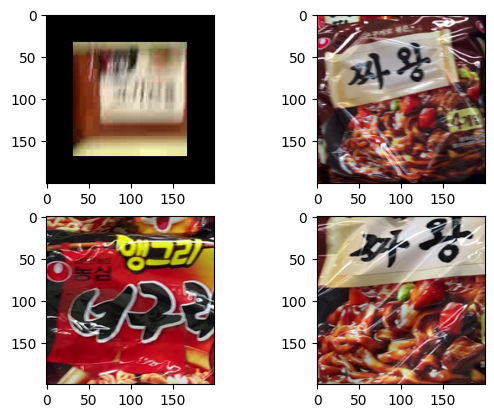

In [33]:

for i in range(len(X_path)):
    img_path = X_path[i]
    img_data=np.zeros((200,200,3))
    img = np.asarray(Image.open(f'{datapath}/{img_path}'))
    ih, iw = img.shape[:2]
    img_data[100-ih//2:100-ih//2+ih,100-iw//2:100-iw//2+iw]=img/255
    X.append(img_data)

fig,axs = plt.subplots(2,2)
for i in range(4):
    axs[i//2,i%2].imshow(X[i])
print(f'{len(X)} datas')

In [35]:
X = np.asarray(X)
y= np.asarray(y)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.2,random_state=42)


In [14]:
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score,f1_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
from keras.callbacks import CSVLogger
score_acc = make_scorer(accuracy_score)
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')

C:\Users\leeyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
params_nn = nn_bo.max['params']
learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn['activation'] = activationL[round(params_nn['activation'])]
params_nn['epochs'] = round(params_nn['epochs'])
params_nn['layers1'] = round(params_nn['layers1'])
params_nn['pooling_size'] = round(params_nn['pooling_size'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['layers3'] = round(params_nn['layers3'])
params_nn['layers4'] = round(params_nn['layers4'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]
print(params_nn)

{'activation': 'relu', 'dropout_prob': 0.21355594928740118, 'dropout_rate': 0.0893324107995704, 'epochs': 79, 'layers1': 11, 'layers2': 13, 'layers3': 76, 'layers4': 55, 'learning_rate': 0.225886505284512, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x000001291C494710>, 'pooling_size': 5}


In [19]:
#이전에 돌려서 얻은 하이퍼파라미터들
#수정함
params_nn={}
params_nn['activation'] = 'relu'
params_nn['epochs'] = 20
params_nn['layers1'] = 11
params_nn['layers2'] = 13
params_nn['layers3'] = 76
params_nn['layers4'] = 55
params_nn['learning_rate'] = 0.225886505284512
params_nn['optimizer'] = 'adam'
params_nn['pooling_size'] = 5
params_nn['dropout_prob'] = 0.2136
params_nn['dropout_rate'] = 0.08933


In [25]:
def optimized_model3():
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200,3)))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Flatten())
  model.add(Dense(params_nn['layers3'], activation=params_nn['activation']))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(layers.Dense(params_nn['layers4'], activation=params_nn['activation']))
  model.add(Dense(50,activation='relu'))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=params_nn['optimizer'],
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

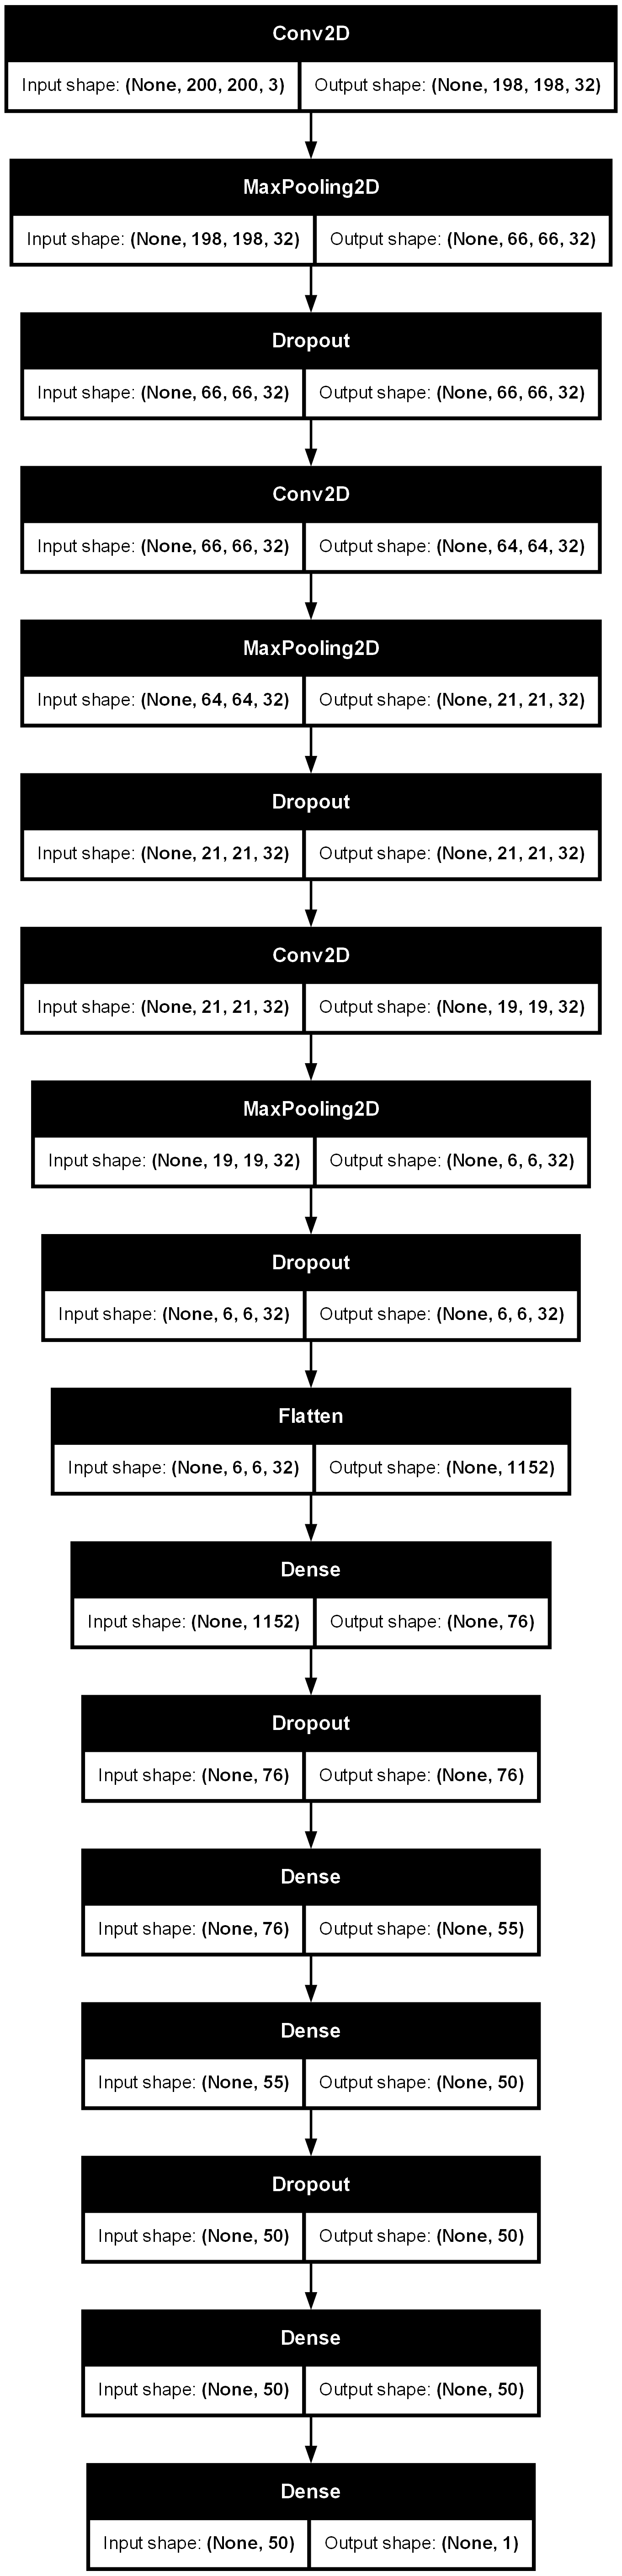

In [26]:
from tensorflow.keras.utils import plot_model
model = optimized_model3()
plot_model(model, to_file='model.png', show_shapes=True)

# Center crop

In [37]:

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=optimized_model3, epochs=params_nn['epochs'], batch_size=200,
                         verbose=0)
nn.fit(train_images, train_labels, validation_data=(test_images, test_labels), verbose=1)
# model.fit(train_images,train_labels,epochs=params_nn['epochs'])
y_predict =nn.predict(test_images, verbose=None)
print(f"""Center-cropped Image
Accuracy : {accuracy_score(test_labels, y_predict)}
F1 Score : {f1_score(test_labels, y_predict, average=None)}
""")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - accuracy: 0.5187 - loss: 0.6922 - val_accuracy: 0.6400 - val_loss: 0.6705
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.5307 - loss: 0.6925 - val_accuracy: 0.6400 - val_loss: 0.6853
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.5322 - loss: 0.6910 - val_accuracy: 0.6400 - val_loss: 0.6811
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.5398 - loss: 0.6888 - val_accuracy: 0.6400 - val_loss: 0.6815
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.5490 - loss: 0.6868 - val_accuracy: 0.6400 - val_loss: 0.6772
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.5325 - loss: 0.6912 - val_accuracy: 0.6350 - val_loss: 0.6839
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.5455 - loss: 0.6898 - val_accuracy: 0.6400 - val_loss: 0.6780
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.5492 - loss: 0.6873 - val_accuracy: 0.6400 - val_loss:

# Padding

1000
1000 data


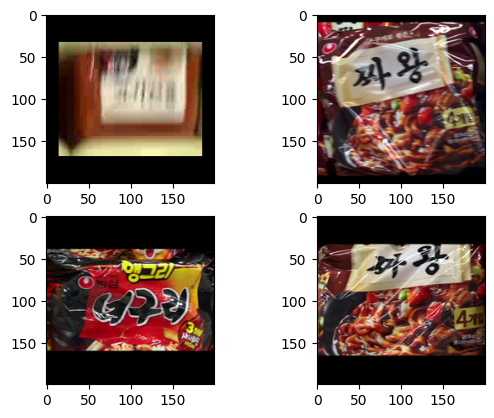

In [10]:
datapath = './test_dataset/padding'
X_path = [f for f in listdir(datapath) if f.endswith('png')]
padding_y=[]
padding_X=[]
#target 레이블 저장
with open(f'{datapath}/{y_path}','r') as label_txt:
    padding_y=list(map(lambda x: int(x.split()[0]),label_txt.readlines()))
    le = LabelEncoder()
    padding_y = le.fit_transform(padding_y)
    label_txt.close()
print(len(X_path))
for i in range(len(X_path)):
    img_path = X_path[i]
    img_data=np.zeros((200,200,3))
    img = np.asarray(Image.open(f'{datapath}/{img_path}'))
    ih, iw = img.shape[:2]
    img_data[100-ih//2:100+ih-ih//2,100-iw//2:100+iw-iw//2]=img/255
    padding_X.append(img_data)

fig,axs = plt.subplots(2,2)
for i in range(4):
    axs[i//2,i%2].imshow(padding_X[i])
print(f'{len(padding_X)} data')
padding_X = np.asarray(padding_X)
padding_y = np.asarray(padding_y)

In [11]:
p_train_images, p_test_images, p_train_labels, p_test_labels = train_test_split(padding_X,padding_y,test_size = 0.2, random_state=42)

In [12]:
print(len(p_train_images))

800


In [38]:
# model = optimized_model2()
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=optimized_model3, epochs=params_nn['epochs'], batch_size=200,
                         verbose=0)
history=nn.fit(p_train_images, p_train_labels, validation_data=(p_test_images, p_test_labels), verbose=1,
               callbacks=[CSVLogger('asd.log', append=True)]
              )
# model.fit(train_images,train_labels, epochs = 15)
# y_predict = np.argmax(model.predict(test_images, verbose=None),axis=1)
y_predict=nn.predict(p_test_images, verbose=None)
print(f"""Padding Image
Accuracy : {accuracy_score(p_test_labels, y_predict)}
F1 Score : {f1_score(p_test_labels, y_predict, average=None)}
""")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step - accuracy: 0.4770 - loss: 0.6962 - val_accuracy: 0.6400 - val_loss: 0.6849
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.5515 - loss: 0.6902 - val_accuracy: 0.6400 - val_loss: 0.6770
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.5385 - loss: 0.6909 - val_accuracy: 0.6400 - val_loss: 0.6828
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step - accuracy: 0.5512 - loss: 0.6888 - val_accuracy: 0.6400 - val_loss: 0.6798
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 527ms/step - accuracy: 0.5348 - loss: 0.6897 - val_accuracy: 0.6400 - val_loss: 0.6791
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.5437 - loss: 0.6884 - val_accuracy: 0.6400 - val_loss: 0.6781
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.5288 - loss: 0.6924 - val_accuracy: 0.6400 - val_loss: 0.6833
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.5413 - loss: 0.6899 - val_accuracy: 0.6400 - val_loss:

padding이 정확도가 더 높다
# 기타 분석

In [39]:
sum(y)/len(y)

0.56

데이터에서 학습된 데이터의 label별 균형이 균일하다. 데이터 불균형에 대해서는 고민할 필요 없을 거 같다.